# Thesis ABM model

Network model between agents that creates stochastic payment shocks then settles payments. Agents are affliliated to a bank. If with the same bank, settlement occurs in period. If with different bank, payment occurs every fourth period due to "batching".

## Configuring the model

In the Black Rhino framework, parameters are stored in xml files. Using this notebook, you can set change them. First, you need to import the elementree from the xml Python module.

In [1]:
import xml.etree.ElementTree as ET

Below you will find the parameter inputs for this model.  

In [2]:
parameter_values = (('num_sweeps', '8'),
                    ('num_simulations', '1'),
                    ('num_households', '8'),
                    ('num_banks', '2'),
                    ('batch', '4'),
                    ('household_directory', 'agents/households'),
                    ('bank_directory', 'agents/banks'),
                    ('measurement_config', 'measurements/test_output.xml')
                   )

To translate this to an xml document, which the framework can read, we first need create an ET element. 

In [3]:
environment = ET.Element('environment')

And create parameter elements and give them the values seen below to add to the tree object.

In [4]:
parameters = []
for x in range(len(parameter_values)):
    parameters.append(ET.SubElement(environment, 'parameter'))
    
for idx, p in enumerate(parameters):
    p.set('type', 'static')
    p.set('name', parameter_values[idx][0])
    p.set('value', parameter_values[idx][1])

This object can now be transformed to a string and written to an xml file using the code below. 

In [5]:
xml_params = ET.tostring(environment, encoding="UTF-8")
myfile = open("environments/solow_parameters.xml", "w")
myfile.write(xml_params)
myfile.close()

Now, the parameter xml file has been generated and the model can be run. Before, running the model, you need to import a couple of extra modules. These are the Python logging module, the Black Rhino environment class, and the Black Rhino runner class.

In [6]:
import logging
import os
from src.environment import Environment
from src.runner import Runner

Then, before running the model, the logger needs to be initialized.

In [7]:
log_directory = "log/"
identifier = "test_all_methods"
environment_directory = "environments/"
if not os.path.exists('log'):
    os.makedirs('log')
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    filename=log_directory + identifier + ".log", level=logging.INFO)
logging.info('START logging for run: %s',  environment_directory + identifier + ".xml")

First, the environment will be initialized. It contains the model parameters and variables. The environment also contains a list of agents. In the Solow model, the environment contains one bank, one firm, and one household. Finally, it also contains initialized transactions for these agents.

In [8]:
environment = Environment(environment_directory, identifier)

Next up, the runner object is created. As the name suggests, the runner object handles the running of the model. But that is not all, it also initializes the updater.

In [9]:
runner = Runner(environment)

Now you can actually run the model. Since the agent-based model is simulated using Monte Carlo methods. This means that the model will be run multiple times (num_simulations). For every simulation run, the environment and runner will be (re-)initialized. Then, the runner will run the Solow model. During the run, the runner will write data about capital to a csv file specified within the Measurement class and print out all the transactions happening and the books of firm and household at the end of each sweep.

In [10]:
for i in range(int(environment.num_simulations)):
    logging.info('  STARTED with run %s',  str(i))
    environment.initialize(environment_directory,  identifier)
    runner.initialize(environment)
    
    runner.do_run(environment)
    logging.info('  DONE')

measurements/test_output.xml
household_1_3s balance is 24.0f
household_1_3s balance is 14.0f
household_1_3s paid 10.0f to bank_1s for household_2_3s at time 0d.
household_2_2s balance is 24.0f
household_2_2s balance is 14.0f
household_2_2s paid 10.0f to bank_2s for household_1_3s at time 0d.
household_2_3s balance is 24.0f
household_2_3s balance is 11.0f
household_2_3s paid 13.0f to bank_2s for household_1_4s at time 0d.
household_2_1s balance is 24.0f
household_2_1s balance is 9.0f
household_2_1s paid 15.0f to bank_2s for household_1_2s at time 0d.
4
1
bank_1s balance is 10.0f
bank_1s balance is 0.0f
bank_1s batch settled payment of 10.0f to household_2_3s at time 0d.
2
bank_2s balance is 38.0f
bank_2s balance is 28.0f
bank_2s batch settled payment of 10.0f to household_1_3s at time 0d.
3
bank_2s balance is 28.0f
bank_2s balance is 15.0f
bank_2s batch settled payment of 13.0f to household_1_4s at time 0d.
4
bank_2s balance is 15.0f
bank_2s balance is 0.0f
bank_2s batch settled payment

In [11]:
import pandas as pd
thesis_data = pd.read_csv('measurements/TestMeasurement.csv', index_col=0) 

In [12]:
print(thesis_data.head())
print(thesis_data.tail())

      Balance  H_1_1  H_1_2  H_2_1  H_2_2  Balance_bank
Step                                                   
1       192.0   21.0   14.0    9.0   24.0           0.0
2       144.0   21.0   14.0    7.0    8.0          48.0
3       129.0   26.0   14.0    5.0    5.0          63.0
4       109.0   20.0   14.0    5.0    2.0          83.0
5       192.0   55.0   30.0   21.0    6.0           0.0
      Balance  H_1_1  H_1_2  H_2_1  H_2_2  Balance_bank
Step                                                   
5       192.0   55.0   30.0   21.0    6.0           0.0
6       139.0   24.0   30.0   14.0    3.0          53.0
7       112.0   24.0   20.0   14.0    3.0          80.0
8        99.0   19.0   20.0   10.0    3.0          93.0
9       192.0   39.0   20.0    8.0   30.0           0.0


In [13]:
import matplotlib.pyplot as plt

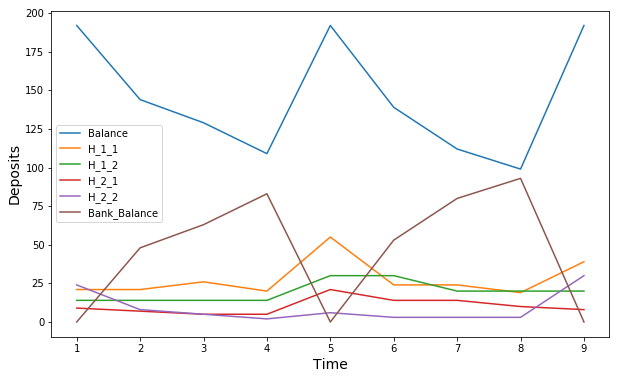

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(thesis_data.index, thesis_data)
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Deposits', fontsize='14')
ax.legend(['Balance', 'H_1_1',  'H_1_2', 'H_2_1', 'H_2_2', 'Bank_Balance'])

fig.savefig('solow_capital.png')

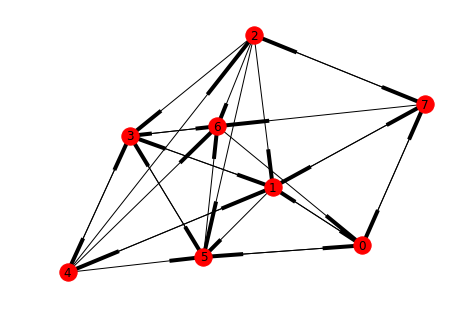

In [16]:
import networkx as nx
nx.draw(environment.network)